In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import cPickle as pickle
sys.path.insert(0,"../python/rrvf2017/")
import rrvf_model as rrvf
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


# Mean of models

In [2]:
def simple_mean(files):
    lst=[pd.read_csv(fname,index_col=0) for fname in files]
    df=0
    for u in lst:
        df=df+np.log1p(u)
    df=df/len(lst)
    df=np.expm1(df)
    return df

In [47]:
!ls ../submission/ -alrt |tail

-rw-rw-r--  1 bo bo  337074 Feb  5 00:52 l3_3001_lgb_foldmean_False_d478.csv.gz
-rw-rw-r--  1 bo bo  337264 Feb  5 04:16 l3_3003_conv_fold0_False_d478.csv.gz
-rw-rw-r--  1 bo bo  337268 Feb  5 04:32 l3_3003_conv_fold2_False_d478.csv.gz
-rw-rw-r--  1 bo bo  337011 Feb  5 04:33 l3_3003_conv_fold1_False_d478.csv.gz
-rw-rw-r--  1 bo bo  259407 Feb  5 13:57 l3_3006_xgb_fold0_False_d478.csv.gz
-rw-rw-r--  1 bo bo  259528 Feb  5 13:57 l3_3006_xgb_fold1_False_d478.csv.gz
-rw-rw-r--  1 bo bo  259100 Feb  5 13:57 l3_3006_xgb_fold2_False_d478.csv.gz
-rw-rw-r--  1 bo bo  259455 Feb  5 13:57 l3_3006_xgb_fold3_False_d478.csv.gz
drwxrwxr-x  2 bo bo   12288 Feb  5 13:57 .
-rw-rw-r--  1 bo bo  259365 Feb  5 13:57 l3_3006_xgb_fold4_False_d478.csv.gz


In [48]:
name='l3_3006_xgb_fold{}_False_d478.csv.gz'  
files=['../submission/'+name.format(i) for i in range(5)]
u=simple_mean(files)

In [49]:
u.to_csv("../submission/"+ name.format('mean'),compression='gzip')

In [6]:
for v in [0.485,0.48,0.475,0.47,0.465]:
    print v, np.sqrt(1-v**2/0.65241814)

0.485 0.799660355031
0.48 0.804271252278
0.475 0.808808489759
0.47 0.813273300315
0.465 0.817666870392


# weighted 

In [3]:
from multiprocessing import Pool

In [4]:
filenames=!ls *.pkl|grep fold4 |grep l4
filenames=[u.replace("fold4",'fold{}') for u in filenames]
filenames

['l4_3000_ridge_fold{}_False_d478.pkl',
 'l4_3001_lgb_fold{}_False_d478.pkl',
 'l4_3003_conv_fold{}_False_d478.pkl',
 'l4_3006_xgb_fold{}_False_d478.pkl']

In [5]:
N_FOLD=5

In [6]:
def f(fname):
    return [ pickle.load(open(fname.format(i))) for i in range(N_FOLD)]

In [7]:
p = Pool(4)

In [8]:
res=p.map(f, filenames)

In [9]:
pkldata=dict(zip(filenames,res))

In [10]:
#pkldata={fname: [ pickle.load(open(fname.format(i))) for i in range(5)] for fname in filenames}

In [11]:
p.close()

In [12]:
pkldata.keys()

['l4_3006_xgb_fold{}_False_d478.pkl',
 'l4_3000_ridge_fold{}_False_d478.pkl',
 'l4_3001_lgb_fold{}_False_d478.pkl',
 'l4_3003_conv_fold{}_False_d478.pkl']

In [13]:
def get_valid_data(fname,offset,fold,return_test=False):
    validpred,testpred=pkldata[fname][fold][offset]
    validdf=pd.DataFrame({"ytrue":np.squeeze(validpred[0]),fname:np.squeeze(validpred[2])},
                         index=[tuple(u) for u in validpred[1]])
    testdf=pd.DataFrame({ fname:np.squeeze(testpred[0])},index=  testpred[1]) if return_test else None
    return validdf,testdf

In [14]:
def show_valid(fold):
    d={}
    for fname in pkldata.keys():
        print fname
        d[fname]={}
        for offset in range(1,40):
            validdf,_=get_valid_data(fname,offset,fold)
            ns=validdf.shape[0]
            validdf=validdf.dropna()
            if ns <> validdf.shape[0]:
                #print "Drop {} records for ".format(ns-validdf.shape[0]),fname,offset,fold
                pass
            score=mean_squared_error(validdf.values[:,0],validdf.values[:,1])
            d[fname][offset]=score
    return d

l4_3006_xgb_fold{}_False_d478.pkl
l4_3000_ridge_fold{}_False_d478.pkl
l4_3001_lgb_fold{}_False_d478.pkl
l4_3003_conv_fold{}_False_d478.pkl
{0: 'l4_3000_ridge_fold{}_False_d478.pkl', 1: 'l4_3001_lgb_fold{}_False_d478.pkl', 2: 'l4_3003_conv_fold{}_False_d478.pkl', 3: 'l4_3006_xgb_fold{}_False_d478.pkl'}


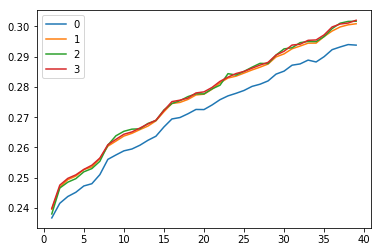

In [15]:
a=show_valid(0)
df=pd.DataFrame(a)
print dict([u for u in (enumerate(df.columns))])
df.columns=range(df.shape[1])
df.plot()

l4_3006_xgb_fold{}_False_d478.pkl
l4_3000_ridge_fold{}_False_d478.pkl
l4_3001_lgb_fold{}_False_d478.pkl
l4_3003_conv_fold{}_False_d478.pkl
{0: 'l4_3000_ridge_fold{}_False_d478.pkl', 1: 'l4_3001_lgb_fold{}_False_d478.pkl', 2: 'l4_3003_conv_fold{}_False_d478.pkl', 3: 'l4_3006_xgb_fold{}_False_d478.pkl'}


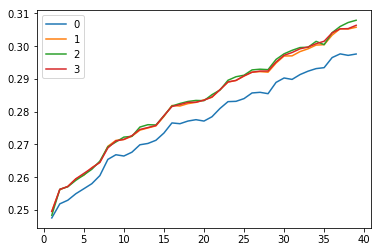

In [16]:
a=show_valid(1)
df=pd.DataFrame(a)
print dict([u for u in (enumerate(df.columns))])
df.columns=range(df.shape[1])
df.plot()

l4_3006_xgb_fold{}_False_d478.pkl
l4_3000_ridge_fold{}_False_d478.pkl
l4_3001_lgb_fold{}_False_d478.pkl
l4_3003_conv_fold{}_False_d478.pkl
{0: 'l4_3000_ridge_fold{}_False_d478.pkl', 1: 'l4_3001_lgb_fold{}_False_d478.pkl', 2: 'l4_3003_conv_fold{}_False_d478.pkl', 3: 'l4_3006_xgb_fold{}_False_d478.pkl'}


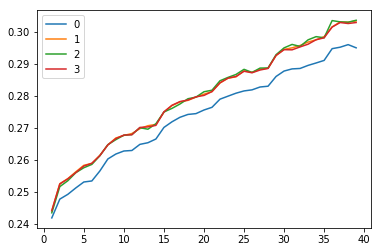

In [17]:
a=show_valid(2)
df=pd.DataFrame(a)
print dict([u for u in (enumerate(df.columns))])
df.columns=range(df.shape[1])
df.plot()

l4_3006_xgb_fold{}_False_d478.pkl
l4_3000_ridge_fold{}_False_d478.pkl
l4_3001_lgb_fold{}_False_d478.pkl
l4_3003_conv_fold{}_False_d478.pkl
{0: 'l4_3000_ridge_fold{}_False_d478.pkl', 1: 'l4_3001_lgb_fold{}_False_d478.pkl', 2: 'l4_3003_conv_fold{}_False_d478.pkl', 3: 'l4_3006_xgb_fold{}_False_d478.pkl'}


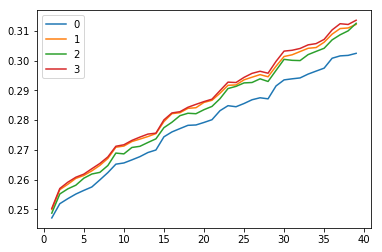

In [18]:
a=show_valid(3)
df=pd.DataFrame(a)
print dict([u for u in (enumerate(df.columns))])
df.columns=range(df.shape[1])
df.plot()

l4_3006_xgb_fold{}_False_d478.pkl
l4_3000_ridge_fold{}_False_d478.pkl
l4_3001_lgb_fold{}_False_d478.pkl
l4_3003_conv_fold{}_False_d478.pkl
{0: 'l4_3000_ridge_fold{}_False_d478.pkl', 1: 'l4_3001_lgb_fold{}_False_d478.pkl', 2: 'l4_3003_conv_fold{}_False_d478.pkl', 3: 'l4_3006_xgb_fold{}_False_d478.pkl'}


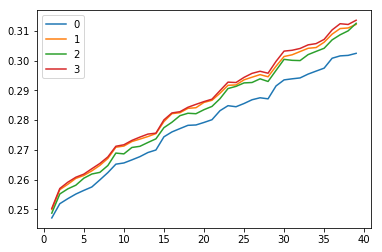

In [19]:
aa=show_valid(4)
df=pd.DataFrame(a)
print dict([u for u in (enumerate(df.columns))])
df.columns=range(df.shape[1])
df.plot()

In [20]:
def get_data_wo_fold():
    d={}
    for fname in pkldata.keys():
        d[fname]={}
        for offset in range(1,40):
            lst1=[];lst2=[]
            for fold in range(N_FOLD):
                validdf,testdf=get_valid_data(fname,offset,fold,return_test=True)
                lst1.append(validdf)
                lst2.append(testdf)
            validdf=pd.concat(lst1)
            testdf=pd.concat(lst2)
            if np.random.random()<0.2:
                print fname,offset,validdf.shape, validdf.dropna().shape, testdf.shape
            d[fname][offset]=[validdf.dropna(),testdf]
    return d
pkdata_wo_fold=get_data_wo_fold()

l4_3006_xgb_fold{}_False_d478.pkl 7 (249239, 2) (249239, 2) (4145, 1)
l4_3006_xgb_fold{}_False_d478.pkl 13 (247695, 2) (247695, 2) (4145, 1)
l4_3006_xgb_fold{}_False_d478.pkl 21 (245580, 2) (245580, 2) (4145, 1)
l4_3006_xgb_fold{}_False_d478.pkl 23 (245003, 2) (245003, 2) (4145, 1)
l4_3006_xgb_fold{}_False_d478.pkl 29 (243443, 2) (243443, 2) (4145, 1)
l4_3006_xgb_fold{}_False_d478.pkl 30 (243159, 2) (243159, 2) (4145, 1)
l4_3006_xgb_fold{}_False_d478.pkl 37 (241318, 2) (241318, 2) (4145, 1)
l4_3006_xgb_fold{}_False_d478.pkl 38 (241104, 2) (241104, 2) (4145, 1)
l4_3006_xgb_fold{}_False_d478.pkl 39 (240868, 2) (240868, 2) (4145, 1)
l4_3000_ridge_fold{}_False_d478.pkl 8 (248949, 2) (248949, 2) (4145, 1)
l4_3000_ridge_fold{}_False_d478.pkl 19 (246135, 2) (246135, 2) (4145, 1)
l4_3000_ridge_fold{}_False_d478.pkl 20 (245861, 2) (245861, 2) (4145, 1)
l4_3000_ridge_fold{}_False_d478.pkl 38 (241104, 2) (241104, 2) (4145, 1)
l4_3001_lgb_fold{}_False_d478.pkl 2 (250457, 2) (250457, 2) (4145, 1)
l

In [21]:
def MSE(y,ypred):
    ind= (~np.isnan(y)) & (~np.isnan(ypred))
    y=y[ind]
    ypred=ypred[ind]
    return mean_squared_error(y,ypred)
def make_l2_features_by_model(filename, pkdata_wo_fold,offset):
    lst1=[];lst2=[]
    for fold in range(5):
        validdf,testdf=get_valid_data(filename,offset,fold,return_test=True)
        lst1.append(validdf)
        lst2.append(testdf)
    valid=pd.concat(lst1)
    #print valid.columns
    y=valid['ytrue'].values
    valid=valid.drop('ytrue',axis=1)
    print filename, MSE(y,valid.iloc[:,0].values)
    test=reduce(lambda u,v: u+v,lst2)/len(lst2)
    test['idx']=test.index.map(lambda u: tuple([u,478]))
    test=test.set_index('idx')
    total=pd.concat([valid,test])
    arr=np.zeros([829,517],dtype=np.float32)*np.nan
    #print total.index
    index=total.index.map(lambda u: tuple([u[0],u[1]+offset-1]))
    arr[zip(*index)]=total.iloc[:,0].values
    return arr
def make_l2_features(pkdata_wo_fold,offset):
    cols=list(pkdata_wo_fold.keys())
    lst=[]
    for col in cols:
        arr=make_l2_features_by_model(col,pkdata_wo_fold,offset)
        lst.append(arr)
    return cols, np.array(lst)


In [22]:
for offset in range(1,40):
    print offset,
    a,b=make_l2_features( pkdata_wo_fold,offset)
    np.savez_compressed("../input/l4_prediction_offset{}.npz".format(offset),columns=a,arr=b)

1 l4_3006_xgb_fold{}_False_d478.pkl 0.245204
l4_3000_ridge_fold{}_False_d478.pkl 0.242615
l4_3001_lgb_fold{}_False_d478.pkl 0.245037324384
l4_3003_conv_fold{}_False_d478.pkl 0.243978722914
2 l4_3006_xgb_fold{}_False_d478.pkl 0.252386
l4_3000_ridge_fold{}_False_d478.pkl 0.247266
l4_3001_lgb_fold{}_False_d478.pkl 0.252042875505
l4_3003_conv_fold{}_False_d478.pkl 0.251539233331
3 l4_3006_xgb_fold{}_False_d478.pkl 0.254374
l4_3000_ridge_fold{}_False_d478.pkl 0.249236
l4_3001_lgb_fold{}_False_d478.pkl 0.254066510793
l4_3003_conv_fold{}_False_d478.pkl 0.25340582835
4 l4_3006_xgb_fold{}_False_d478.pkl 0.255946
l4_3000_ridge_fold{}_False_d478.pkl 0.250772
l4_3001_lgb_fold{}_False_d478.pkl 0.255802857154
l4_3003_conv_fold{}_False_d478.pkl 0.25495659529
5 l4_3006_xgb_fold{}_False_d478.pkl 0.257623
l4_3000_ridge_fold{}_False_d478.pkl 0.252525
l4_3001_lgb_fold{}_False_d478.pkl 0.25744077769
l4_3003_conv_fold{}_False_d478.pkl 0.256963675725
6 l4_3006_xgb_fold{}_False_d478.pkl 0.258952
l4_3000_ridge

In [23]:
str(a)

"['l4_3006_xgb_fold{}_False_d478.pkl', 'l4_3000_ridge_fold{}_False_d478.pkl', 'l4_3001_lgb_fold{}_False_d478.pkl', 'l4_3003_conv_fold{}_False_d478.pkl']"

In [24]:
#c=make_l2_features_by_model('3001_lgb_fold{}_False_d478.pkl', pkdata_wo_fold,2)

In [24]:
def show_valid():
    d={}
    for fname in pkdata_wo_fold.keys():
        print fname
        d[fname]={}
        for offset in range(1,40):
            validdf,_=pkdata_wo_fold[fname][offset]
            ns=validdf.shape[0]
            validdf=validdf.dropna()
            if ns <> validdf.shape[0]:
                print "Drop {} records for ".format(ns-validdf.shape[0]),fname,offset,fold
                pass
            score=mean_squared_error(validdf.values[:,0],validdf.values[:,1])
            d[fname][offset]=score
    return d

l4_3006_xgb_fold{}_False_d478.pkl
l4_3000_ridge_fold{}_False_d478.pkl
l4_3001_lgb_fold{}_False_d478.pkl
l4_3003_conv_fold{}_False_d478.pkl
{0: 'l4_3000_ridge_fold{}_False_d478.pkl', 1: 'l4_3001_lgb_fold{}_False_d478.pkl', 2: 'l4_3003_conv_fold{}_False_d478.pkl', 3: 'l4_3006_xgb_fold{}_False_d478.pkl'}


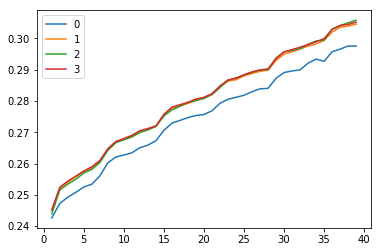

In [25]:
aa=show_valid()
df=pd.DataFrame(aa)
print dict([u for u in (enumerate(df.columns))])
df.columns=range(df.shape[1])
df.plot()

In [26]:
def get_valid_pred(offset):
    lst=[]
    for fname in pkdata_wo_fold:
        s=pkdata_wo_fold[fname][offset][0]
        lst.append(s)
    df=pd.concat(lst,axis=1)
    return df

In [27]:
def evaluate(offset):
    a=get_valid_pred(offset)
    a=a.dropna()
    X=a[[u for u in a.columns if u<>'ytrue']].values
    y=a['ytrue'].iloc[:,0].values
    W=rrvf.make_weights(X.T,y,np.ones_like(y))
    return dict(zip([u for u in a.columns if u<>'ytrue'],W))


In [28]:
lst={}
for offset in range(1,40):
    print offset
    lst[offset]=evaluate(offset)

1
individual loss [ 0.24392384  0.24134438  0.24376365  0.24397872]
[ 0.06666727  0.81885333  0.          0.1144794 ] 0.241243585023
2
individual loss [ 0.25106554  0.2459994   0.25076055  0.25153923]
[  1.55758631e-17   1.00000000e+00   0.00000000e+00   0.00000000e+00] 0.245999404818
3
individual loss [ 0.25308012  0.24797022  0.25279588  0.25340583]
[  0.00000000e+00   1.00000000e+00  -1.10412514e-16   0.00000000e+00] 0.247970222548
4
individual loss [ 0.25489053  0.2497628   0.25479218  0.2549566 ]
[ -1.67068539e-17   1.00000000e+00   4.75910752e-19   0.00000000e+00] 0.249762797383
5
individual loss [ 0.25661885  0.25154655  0.25646912  0.25696368]
[  5.37270726e-18   1.00000000e+00   8.09138726e-17  -3.46944695e-18] 0.251546548264
6
individual loss [ 0.25803558  0.25251834  0.25771217  0.25812132]
[ -2.19892150e-17   1.00000000e+00   1.12569203e-16   0.00000000e+00] 0.252518342847
7
individual loss [ 0.25994893  0.2550312   0.25975558  0.26032352]
[  0.00000000e+00   1.00000000e+00

{0: 'l4_3000_ridge_fold{}_False_d478.pkl', 1: 'l4_3001_lgb_fold{}_False_d478.pkl', 2: 'l4_3003_conv_fold{}_False_d478.pkl', 3: 'l4_3006_xgb_fold{}_False_d478.pkl'}


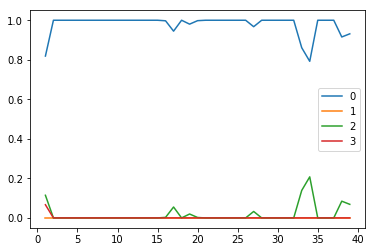

In [29]:
df=pd.DataFrame(lst).T
print dict(enumerate(df.columns))
df.columns=range(df.shape[1])
df.plot()